In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip -qq /content/drive/MyDrive/datasets.zip -d /content/drive/MyDrive/dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
# dataset_url = "/content/drive/MyDrive/datasettwo/dataset"
# data_dir = tf.keras.utils.get_file('dataset', origin=dataset_url, untar=True)
data_dir = "/content/drive/MyDrive/dataset/"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('A/*.png')))
print(image_count)
image_count = len(list(data_dir.glob('lower_a/*.png')))
print(image_count)

1501
1501
1501
1501


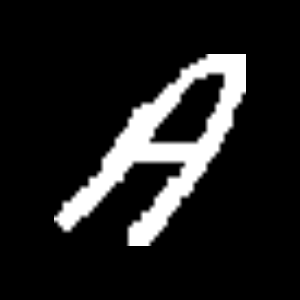

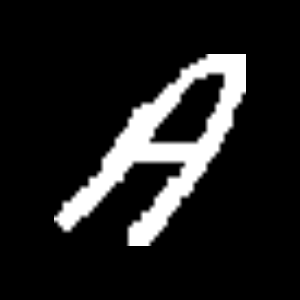

In [ ]:
A = list(data_dir.glob('A/*'))
PIL.Image.open(str(A[0]))

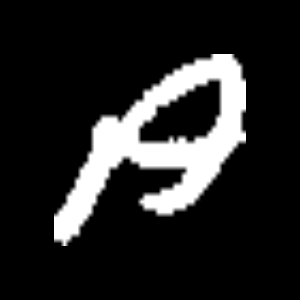

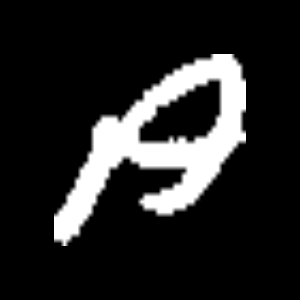

In [ ]:
PIL.Image.open(str(A[1]))

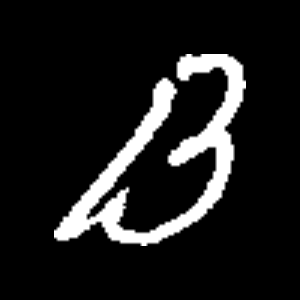

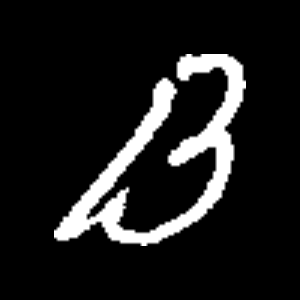

In [ ]:
B = list(data_dir.glob('B/*'))
PIL.Image.open(str(B[0]))

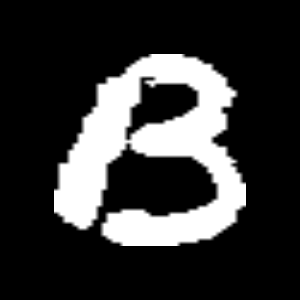

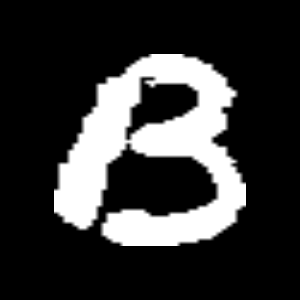

In [ ]:
PIL.Image.open(str(B[1]))

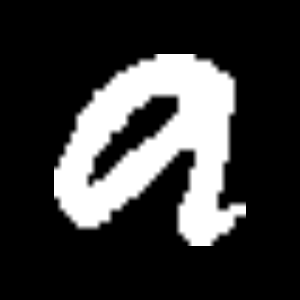

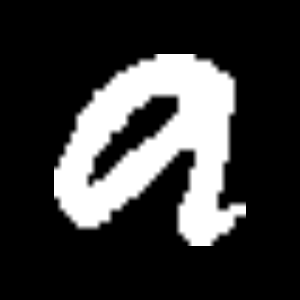

In [ ]:
lower_a = list(data_dir.glob('lower_a/*'))
PIL.Image.open(str(lower_a[0]))

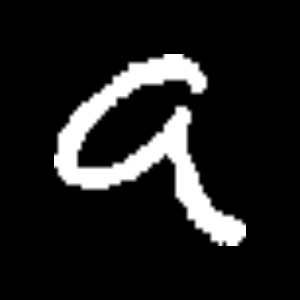

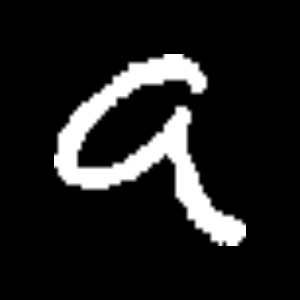

In [ ]:
PIL.Image.open(str(lower_a[1]))

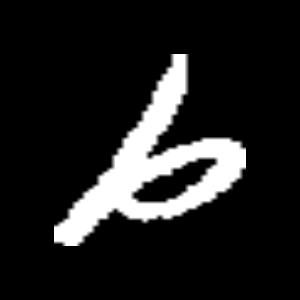

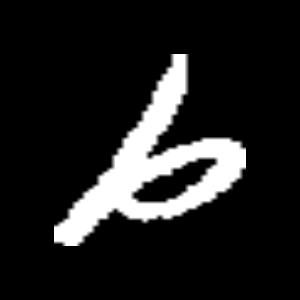

In [ ]:
lower_b = list(data_dir.glob('lower_b/*'))
PIL.Image.open(str(lower_b[0]))

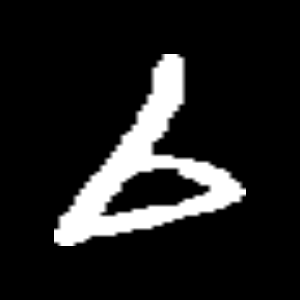

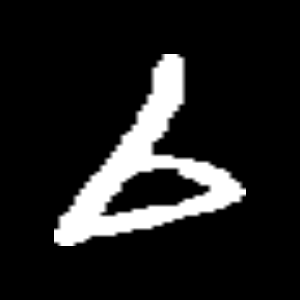

In [ ]:
PIL.Image.open(str(lower_b[1]))

In [ ]:
#데이터셋 만들기
batch_size = 32
img_height = 180
img_width = 180

#훈련 데이터, 검증 데이터 나누기
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 78052 files belonging to 52 classes.
Using 62442 files for training.
Found 78052 files belonging to 52 classes.
Using 15610 files for validation.
Found 78052 files belonging to 52 classes.
Using 62442 files for training.
Found 78052 files belonging to 52 classes.
Using 15610 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'lower_a', 'lower_b', 'lower_c', 'lower_d', 'lower_e', 'lower_f', 'lower_g', 'lower_h', 'lower_i', 'lower_j', 'lower_k', 'lower_l', 'lower_m', 'lower_n', 'lower_o', 'lower_p', 'lower_q', 'lower_r', 'lower_s', 'lower_t', 'lower_u', 'lower_v', 'lower_w', 'lower_x', 'lower_y', 'lower_z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'lower_a', 'lower_b', 'lower_c', 'lower_d', 'lower_e', 'lower_f', 'lower_g', 'lower_h', 'lower_i', 'lower_j', 'lower_k', 'lower_l', 'lower_m', 'lower_n', 'lower_o', 'lower_p', 'lower_q', 'lower_r', 'lower_s', 'lower_t', 'lower_u', 'lower_v', 'lower_w', 'lower_x', 'lower_y', 'lower_z']


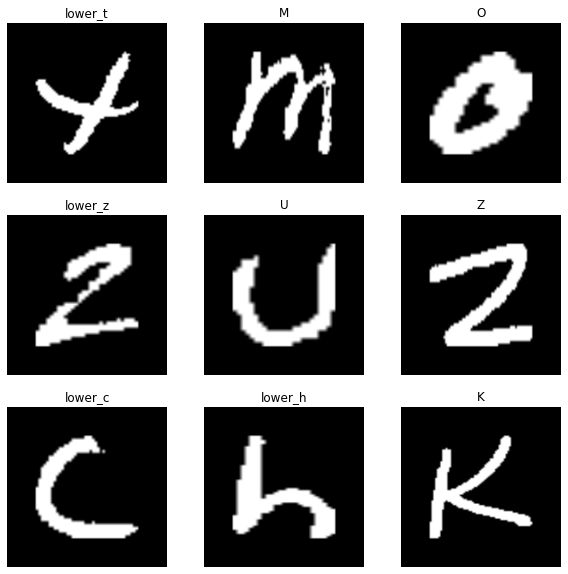

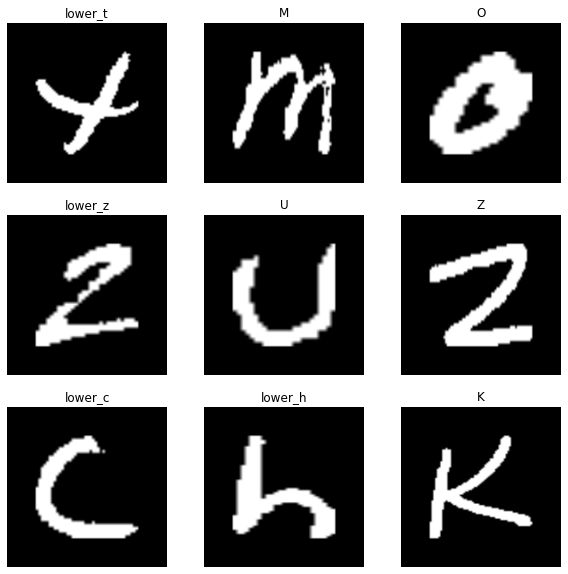

In [ ]:
#데이터 시각화하기
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


In [ ]:
#데이터 표준화하기
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0
0.0 1.0


In [ ]:
#데이터 증강
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

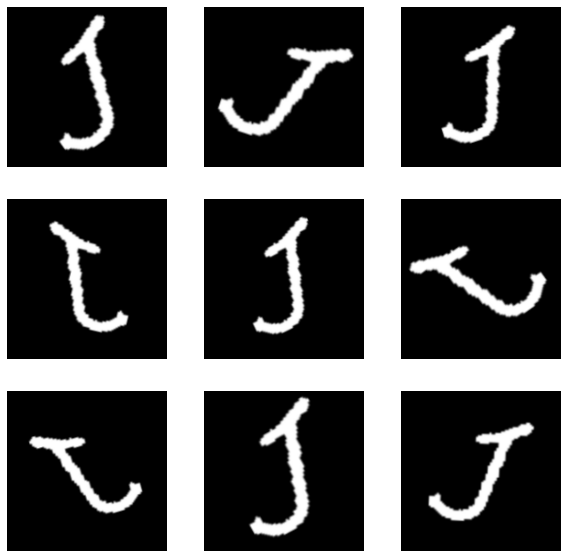

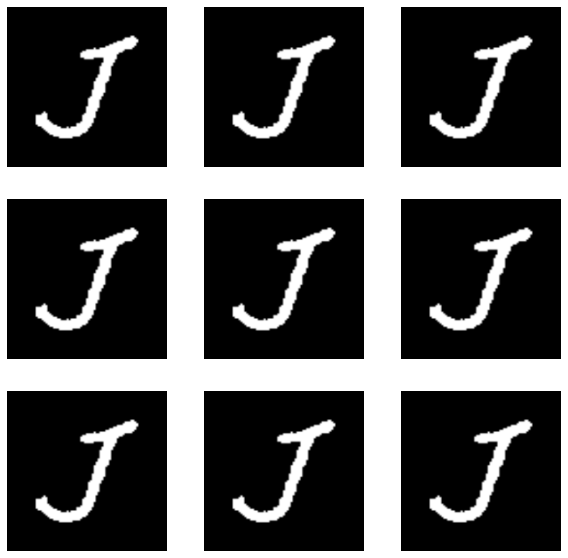

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#모델 만들기
num_classes = 52

In [ ]:
#드롭 아웃
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#모델 컴파일하기
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#모델 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
#모델 훈련하기
epochs=3
# epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
1952/1952 [==============================] - 2450s 1s/step - loss: 1.8458 - accuracy: 0.4446 - val_loss: 1.2881 - val_accuracy: 0.5637
Epoch 2/3
1952/1952 [==============================] - 2432s 1s/step - loss: 1.2698 - accuracy: 0.5758 - val_loss: 1.1308 - val_accuracy: 0.6086
Epoch 3/3
1952/1952 [==============================] - 2409s 1s/step - loss: 1.1260 - accuracy: 0.6089 - val_loss: 1.0975 - val_accuracy: 0.6220
Epoch 1/3
1033/1952 [==============>...............] - ETA: 17:44 - loss: 2.1150 - accuracy: 0.3851

KeyboardInterrupt: ignored

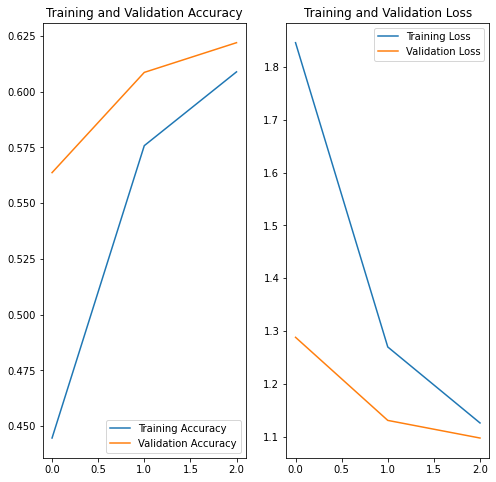

In [ ]:
#훈련 결과 시각화하기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#새로운 데이터로 예측하기
# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
L_path = '/content/drive/MyDrive/datasettwo/dataset/test/K/000000.png'

img = keras.preprocessing.image.load_img(
    # sunflower_path, target_size=(img_height, img_width)
    L_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to lower_k with a 45.23 percent confidence.
